In [8]:
import boto3
import botocore
import sagemaker
import sys

In [9]:
bucket = 'scientist-13-jon'   # <--- specify a bucket you have access to
prefix = 'sagemaker/fraud'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://scientist-13-jon/sagemaker/fraud


In [22]:
df = pd.read_csv("fraud_reduced.csv")

In [23]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [16]:
df.shape

(6362620, 10)

In [12]:
filename = "fraud_reduced.csv"
s3_filename = '{}/{}'.format(prefix, filename)

s3 = boto3.resource('s3')
s3.meta.client.upload_file(filename, bucket, s3_filename)

In [13]:
print('Data uploaded as: s3://{}/{}'.format(bucket, s3_filename))

Data uploaded as: s3://scientist-13-jon/sagemaker/fraud/fraud_reduced.csv


Does it make sense to pass in df.isFraud? why only the single column?

In [17]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df.isFraud.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-13-15-59-57-398


2019-03-13 15:59:57 Starting - Starting the training job...
2019-03-13 16:00:01 Starting - Launching requested ML instances......
2019-03-13 16:01:12 Starting - Preparing the instances for training......
2019-03-13 16:02:23 Downloading - Downloading input data...
2019-03-13 16:02:43 Training - Downloading the training image...
2019-03-13 16:03:21 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[03/13/2019 16:03:23 INFO 140341574838080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/13/2019 16:03:23 INFO 140341574838080] R

[2019-03-13 16:03:35.073] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 10120, "num_examples": 6363, "num_bytes": 178153360}
[03/13/2019 16:03:35 INFO 140341574838080] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 10130.580186843872, "sum": 10130.580186843872, "min": 10130.580186843872}}, "EndTime": 1552493015.08307, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1552493004.94324}

[03/13/2019 16:03:35 INFO 140341574838080] Early stop condition met. Stopping training.
[03/13/2019 16:03:35 INFO 140341574838080] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of Batches Since Last Reset": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of Re

In [18]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-13-16-05-30-292
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-13-15-59-57-398


---------------------------------------------------------------------------------------!

In [19]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-03-13-15-59-57-398


In [20]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer


In [48]:
df_numpy = df.isFraud.as_matrix().reshape(-1,1)
print(df_numpy[:6])
results = rcf_inference.predict(df_numpy[:6])

[[0]
 [0]
 [1]
 [1]
 [0]
 [0]]


I was getting timeout errors running the predictions against the 6million rows, so let's do a subset

In [49]:
df_numpy = df_numpy[:60000]
df_small = df[:60000]

In [50]:
results = rcf_inference.predict(df_numpy)
scores = [datum['score'] for datum in results['scores']]

In [51]:
scores

[0.5295768137,
 0.5295768137,
 8.0592670106,
 8.0592670106,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768137,
 0.5295768

In [52]:
# add scores to taxi data frame and print first few values
df_small['score'] = pd.Series(scores, index=df_small.index)
df_small.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,score
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0.529577
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0.529577
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,8.059267
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,8.059267
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0.529577


In [53]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100


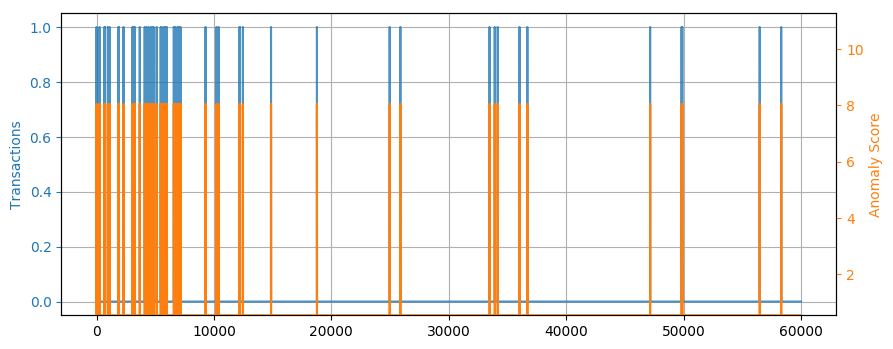

In [54]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df_small)
#start, end = 5500, 6500
df_subset = df_small[start:end]

ax1.plot(df_subset['isFraud'], color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Transactions', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)